# <font color='black'>Introduction to Machine Learning</font>




The objective of this  session is to introduce and code your first neural network.


## <font color='black'>Set-Up</font>

---

First we will import the packages that we will need throughout the notebook.

In [19]:
import os
import numpy as np
from matplotlib import pyplot
from scipy import optimize
from scipy.io import loadmat
import utils

# tells matplotlib to embed plots within the notebook
%matplotlib inline

## <font color='black'>Neural Networks</font>

---
In this session, you will implement a neural network to recognize handwritten digits. The neural network will be able to represent complex models that form non-linear hypotheses. In the first part, you will be using parameters from a neural network that have already been trained. You will first  implement the feedforward propagation to use the weights for prediction.

We start by loading and visualizing the dataset which contains the classical MNIST handwritten digits.  


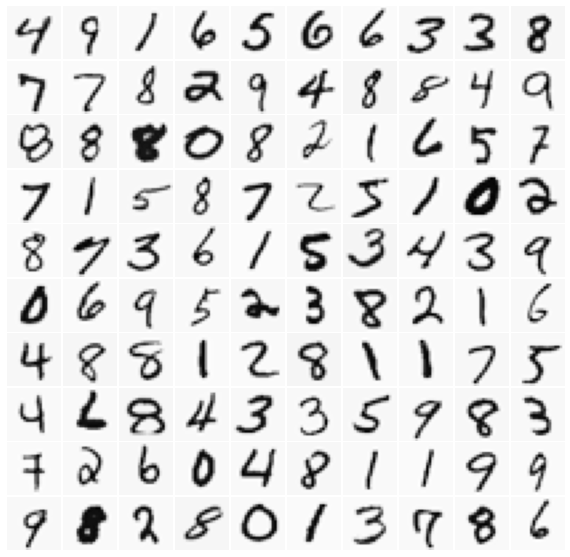

In [20]:
#  training data stored in arrays X, y
data = loadmat(os.path.join('Data', 'ex3data1.mat'))
X, y = data['X'], data['y'].ravel()

# set the zero digit to 0, rather than its mapped 10 in this dataset
y[y == 10] = 0

# get number of examples in dataset
m = y.size

# randomly permute examples, to be used for visualizing one 
# picture at a time
indices = np.random.permutation(m)

# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

utils.displayData(sel)

In [21]:
X.shape

(5000, 400)


### Model representation 

Your first neural network has 3 layers: an input layer, a hidden layer and an output layer. 

You have been provided with a set of network parameters ($\Theta^{(1)}$, $\Theta^{(2)}$) already trained. These are stored in `ex3weights.mat`. The following cell loads those parameters into  `Theta1` and `Theta2`. The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

In [22]:
# Setup the parameters you will use for this exercise
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 0 to 9

# Load the .mat file, which returns a dictionary 
weights = loadmat(os.path.join('Data', 'ex3weights.mat'))

# get the model weights from the dictionary
# Theta1 has size 25 x 401
# Theta2 has size 10 x 26
Theta1, Theta2 = weights['Theta1'], weights['Theta2']
Theta2 = np.roll(Theta2, 1, axis=0)

###  Feedforward Propagation and Prediction

Now you will implement feedforward propagation for the neural network. 

In [23]:
def predict(Theta1, Theta2, X):    
  
    # Make sure the input has two dimensions
    if X.ndim == 1:
        X = X[None]  # promote to 2-dimensions
    
    # useful variables
    m = X.shape[0]
    num_labels = Theta2.shape[0]

    # You need to return the following variables correctly 
    p = np.zeros(X.shape[0])

    # ====================== YOUR CODE HERE ======================

    X_copy = np.copy(X)
    
    vect_one = np.ones((m, 1))
    X_copy = np.concatenate((vect_one, X_copy), axis = 1)

    hidden = np.dot(Theta1, X_copy.T)
    hidden = 1/(1 + np.exp(-hidden))

    vect_one = np.ones((1, m))
    hidden = np.concatenate((vect_one, hidden), axis = 0)

    final = np.dot(Theta2, hidden)
    
    p = np.argmax(final, axis = 0)
    
    # =============================================================
    return p

Once you are done, call your predict function using the loaded set of parameters for `Theta1` and `Theta2`. You should see that the accuracy is about 97.5%.

In [24]:
pred = predict(Theta1, Theta2, X)
print('Training Set Accuracy: {:.1f}%'.format(np.mean(pred == y) * 100))

Training Set Accuracy: 97.5%


Now you can  display some images from the training set one at a time, while at the same time printing out the predicted label for the displayed image.

Neural Network Prediction: 5


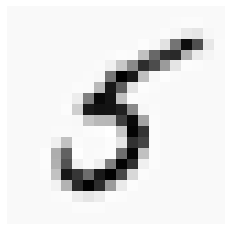

In [25]:
if indices.size > 0:
    i, indices = indices[0], indices[1:]
    utils.displayData(X[i, :], figsize=(4, 4))
    pred = predict(Theta1, Theta2, X[i, :])
    print('Neural Network Prediction: {}'.format(*pred))
else:
    print('No more images to display!')

# Backpropagation
---

In the first part, you implemented forward propagation for neural networks and used it to predict handwritten digits with the weights provided. Now, you will implement the backpropagation algorithm to learn the parameters for the neural network.

In [26]:
# Unroll parameters 
nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()])

### Feedforward and cost function

Now you will implement the cost function and gradient for the neural network. First, complete the code for the function `nnCostFunction` in the next cell to return the cost.

Recall that the cost function for the neural network (without regularization) is:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right]$$

where $h_\theta \left( x^{(i)} \right)$ is the output of the NN, and K = 10 is the total number of possible labels.  You need to encode the labels as vectors containing only values 0 or 1, so that

$$ y = 
\begin{bmatrix} 1 \\ 0 \\ 0 \\\vdots \\ 0 \end{bmatrix}, \quad
\begin{bmatrix} 0 \\ 1 \\ 0 \\ \vdots \\ 0 \end{bmatrix}, \quad \cdots  \quad \text{or} \qquad
\begin{bmatrix} 0 \\ 0 \\ 0 \\ \vdots \\ 1 \end{bmatrix}.
$$

For example, if $x^{(i)}$ is an image of the digit 5, then the corresponding $y^{(i)}$ (that you should use with the cost function) should be a 10-dimensional vector with $y_5 = 1$, and the other elements equal to 0.

You need to implement the forward pass that comptes  $h_\theta(x^{(i)})$ for every example $i$ and sum the cost over all examples. 

In [27]:
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_=0.0):
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for the 2 layer neural network
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1)))

    Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)))
    # Setup some useful variables
    m = y.size
         
    # You need to return the following variables correctly 
    J = 0
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)

    # ====================== YOUR CODE HERE ======================

    X_copy = X.copy()
    X_copy = np.concatenate( [np.ones((m, 1)), X_copy], axis = 1 )

    Y = np.zeros((num_labels, m))

    for i in range(m):
        Y[y[i], i] = 1
    

    # previous function
    hidden = np.dot(Theta1, X_copy.T)
    hidden = 1/(1 + np.exp(-hidden))
    tmp = np.concatenate([np.ones((1, m)), hidden], axis = 0)
    output = np.dot(Theta2, tmp)

    h = 1/(1 + np.exp(-output))

    J = 1/m * (-Y*np.log(h) - (1-Y)*np.log(1-h))
    J = np.sum(np.sum(J, axis = 0))


    # ================================================================

    
    grad = np.concatenate([Theta1_grad.ravel(), Theta2_grad.ravel()])

    return J, grad

Once you are done, call your `nnCostFunction` using the loaded set of parameters for `Theta1` and `Theta2`. You should see that the cost is about 0.287629.

In [28]:
lambda_ = 0
J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,num_labels, X, y, lambda_)
print('Cost at parameters (loaded from ex4weights): %.6f ' % J)

Cost at parameters (loaded from ex4weights): 0.287629 


### Regularized cost function

The cost function for neural networks with regularization is given by:


$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right] + \frac{\lambda}{2 m} \left[ \sum_{j=1}^{25} \sum_{k=1}^{400} \left( \Theta_{j,k}^{(1)} \right)^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} \left( \Theta_{j,k}^{(2)} \right)^2 \right] $$

You can assume that the neural network will only have 3 layers - an input layer, a hidden layer and an output layer. 

Recall that you should not be regularizing the terms that correspond to the bias. For the matrices `Theta1` and `Theta2`, this corresponds to the first column of each matrix. You should now add regularization to your cost function. Notice that you can first compute the unregularized cost function $J$ using your existing `nnCostFunction` and then later add the cost for the regularization terms.

Once you are done, the next cell will call your `nnCostFunction` using the loaded set of parameters for `Theta1` and `Theta2`, and $\lambda = 1$. You should see that the cost is about 0.383770.

In [29]:
# Weight regularization parameter (we set this to 1 here).
lambda_ = 10000
J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                      num_labels, X, y, lambda_)

print('Cost at parameters (loaded from ex4weights): %.6f' % J)

Cost at parameters (loaded from ex4weights): 0.287629


##  Backpropagation

You will implement now the backpropagation algorithm to compute the gradient for the neural network cost function. You will need to update the function `nnCostFunction` so that it returns an appropriate value for `grad`. 

You will start implementing the backpropagation algorithm for the parameters for the (unregularized) neural network. Afterwards, you will implement the gradient for the regularized neural network.

### Sigmoid Gradient

You will first implement the sigmoid gradient function. The gradient for the sigmoid function can be
computed as

$$ g'(z) = \frac{d}{dz} g(z) = g(z)\left(1-g(z)\right) $$

where

$$ \text{sigmoid}(z) = g(z) = \frac{1}{1 + e^{-z}} $$

Now complete the implementation of `sigmoidGradient` in the next cell.

In [30]:
def sigmoidGradient(z):

    g = np.zeros(z.shape)

    # ====================== YOUR CODE HERE ======================
    g = 1/(1 + np.exp(-z))
    g = g*(1-g)
    # =============================================================
    return g

Try testing a few values by calling `sigmoidGradient(z)`. For large values (both positive and negative) of z, the gradient should be close to 0. When $z = 0$, the gradient should be exactly 0.25. 

In [31]:
z = np.array([-1, -0.5, 0, 0.5, 1])
g = sigmoidGradient(z)
print('Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:\n  ')
print(g)

Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:
  
[0.19661193 0.23500371 0.25       0.23500371 0.19661193]


## Random Initialization

When training neural networks, it is important to randomly initialize the parameters for symmetry breaking. One effective strategy for random initialization is to randomly select values for $\Theta^{(l)}$ uniformly in the range $[-\varepsilon_{init}, \varepsilon_{init}]$. You should use $\varepsilon_{init} = 0.12$. This range of values ensures that the parameters are kept small and makes the learning more efficient.

In [32]:
def randInitializeWeights(L_in, L_out, epsilon_init=0.12):

    W = np.zeros((L_out, 1 + L_in))
    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init

    return W

Execute the following cell to initialize the weights for the 2 layers in the neural network using the `randInitializeWeights` function.

In [33]:
print('Initializing Neural Network Parameters ...')

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

# Unroll parameters
initial_nn_params = np.concatenate([initial_Theta1.ravel(), initial_Theta2.ravel()], axis=0)

Initializing Neural Network Parameters ...


In [34]:
#  You can change the maxiter to a larger
#  value to see how more training helps.
options= {'maxiter': 100}

#  You could also try different values of lambda
lambda_ = 1

costFunction = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_)
res = optimize.minimize(costFunction,initial_nn_params,jac=True,method='TNC',options=options)
nn_params = res.x
        
# Obtain Theta1 and Theta2 back from nn_params
Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                    (hidden_layer_size, (input_layer_size + 1)))

Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                    (num_labels, (hidden_layer_size + 1)))

In [35]:
pred = utils.predict(Theta1, Theta2, X)
print('Training Set Accuracy: %f' % (np.mean(pred == y) * 100))

Training Set Accuracy: 10.000000


One way to understand what your neural network is learning is to visualize what the representations captured by the hidden units. 

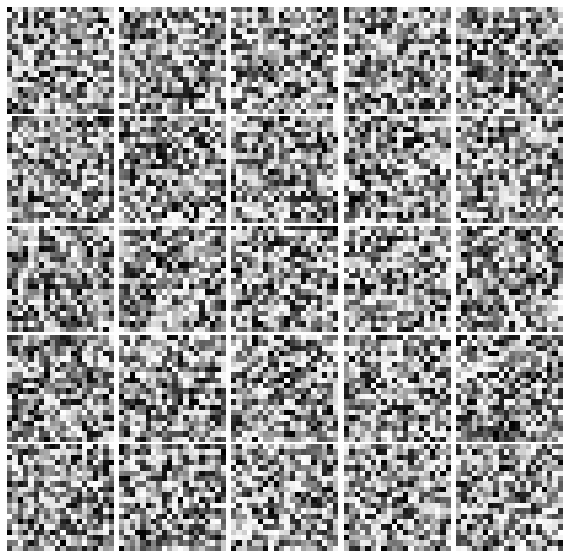

In [36]:
utils.displayData(Theta1[:, 1:])